In [1]:
# this script will download flow and stage instantaneous data from Environment Canada
# https://eccc-msc.github.io/open-data/msc-data/obs_hydrometric/readme_hydrometric-datamart_en/ 
import cwms
from datetime import datetime, timedelta
import json
import pandas as pd

In [2]:
# load .env python environment for storing API_KEY
# .env file can be stored a parent directory of script
# https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1
from dotenv import load_dotenv
import os

In [3]:
def ecccParser(url, params, snapTo5Minutes = True) -> pd.DataFrame:

    prov, id, freq = params
    url = 'https://dd.weather.gc.ca/hydrometric/csv/'+prov+'/'+freq+'/'+prov+'_'+id+'_'+freq+'_hydrometric.csv'
    print(url)
    try:
        df = pd.read_csv(url)
    except:
        print(url+' failed')
        df = pd.DataFrame()

    if df.empty==False:
        df['Date']= pd.to_datetime(df['Date'])
        # need to convert from '2024-02-16 08:30:00-06:00' format to '2024-02-16 14:30:00' so it stores in CWMS correctly
        df['Date'] = df['Date'].values 
        # will snap to the nearest 5 minutes if true
        if snapTo5Minutes:
            df = check_and_shift_to_5min(df, 'Date')
        dfStage = df[["Date", "Water Level / Niveau d'eau (m)"]]
        dfStage.columns = ['date', 'value']
        #drop any na values
        dfStage = dfStage.dropna()
        dfFlow = df[["Date", "Discharge / Débit (cms)"]]
        dfFlow.columns = ['date', 'value']
        #drop any na values
        dfFlow = dfFlow.dropna()
        return dfStage, dfFlow
    else:
           return None, None 


def store_eccValues(df, ts_id, units, officeId, qualityCode):
    values = df.reindex(columns=['date','value'])
    #adjust column names to fit cwms-python format.
    values = values.rename(columns={'date': 'date-time', 'value': 'value'})
    values['quality-code'] = qualityCode 

    data = cwms.timeseries_df_to_json(data = values, ts_id = ts_id, units = units, office_id = officeId)
    
    #write values to CWMS database
    try:
        x = cwms.store_timeseries(data=data)
        print(f'Stored values in {ts_id}')
    except:
        storErr.append(ts_id)
        print(f'Error in storing {ts_id}')

def check_even_5min_interval(df, datetime_col):
    """Checks if a datetime column is on an even 5-minute interval."""
    tmpDf = df.copy()
    
    tmpDf[datetime_col] = pd.to_datetime(tmpDf[datetime_col])

    tmpDf['time_diff'] = tmpDf[datetime_col].diff()
    tmpDf['time_diff_minutes'] = tmpDf['time_diff'].dt.total_seconds() / 60

    # Check if all time differences are multiples of 5
    return (tmpDf['time_diff_minutes'] % 5 == 0).all()

def check_and_shift_to_5min(df, datetime_col):
    """
    Checks if a datetime column is on a 5-minute interval and shifts data if not.

    Args:
        df (pd.DataFrame): The DataFrame containing the datetime column.
        datetime_col (str): The name of the datetime column.

    Returns:
        pd.DataFrame: The DataFrame with the datetime column on a 5-minute interval.
    """
    tmpDf = df.copy()

    # Convert the column to datetime if it's not already
    tmpDf[datetime_col] = pd.to_datetime(tmpDf[datetime_col])


    is_5min_interval = check_even_5min_interval(tmpDf.copy(), datetime_col)

    if not is_5min_interval:
        # Round the datetime column to the nearest 5 minutes
        tmpDf[datetime_col] = tmpDf[datetime_col].dt.round('5min')
    
    #tmpDf.dropna(subset=['value'], inplace=True)

    return tmpDf

#from https://eccc-msc.github.io/open-data/msc-data/obs_hydrometric/readme_hydrometric-datamart_en/
url = 'https://dd.weather.gc.ca/hydrometric/csv/'


In [4]:
#default apiroot
#cwms.api.return_base_url()

In [5]:
# grab API variables from .env file
load_dotenv()
APIROOT = os.getenv("API_ROOT")
OFFICE = os.getenv("OFFICE")
APIKEY = os.getenv('API_KEY')


In [6]:
# api key needs to have the test "apikey" as a prefix to work with CDA 
apiKey = "apikey " + APIKEY

In [7]:
api = cwms.api.init_session(api_root = APIROOT, api_key = apiKey)
#defined apiroot
#cwms.api.return_base_url()

# Setup ECCC aliases in CWMS-VUE Location Groups

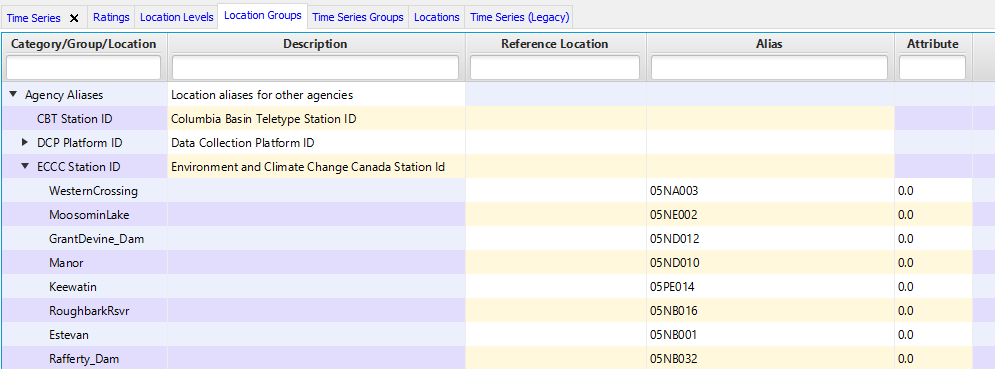

# Create ECCC timeseries group in CWMS-VUE and populate with timeseries

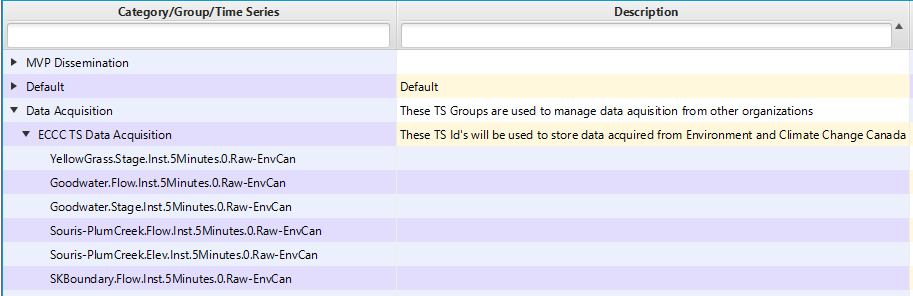


In [8]:

# get ECCC timeseries group
df = cwms.get_timeseries_group(group_id="ECCC TS Data Acquisition",category_id="Data Acquisition",office_id="CWMS").df
# parse out the time seried id into components
df[['location-id','param','type','int','dur','ver']] = df['timeseries-id'].str.split('.', expand=True)
df

,office-id,timeseries-id,ts-code,location-id,param,type,int,dur,ver
0,MVP,WesternCrossing.Flow.Inst.5Minutes.0.Raw-EnvCan,28985016,WesternCrossing,Flow,Inst,5Minutes,0,Raw-EnvCan
1,MVP,WesternCrossing.Stage.Inst.5Minutes.0.Raw-EnvCan,28986016,WesternCrossing,Stage,Inst,5Minutes,0,Raw-EnvCan
2,MVP,WesternCrossing.Elev.Inst.5Minutes.0.Raw-EnvCan,1231067016,WesternCrossing,Elev,Inst,5Minutes,0,Raw-EnvCan
3,MVP,Radville.Flow.Inst.5Minutes.0.Raw-EnvCan,28987016,Radville,Flow,Inst,5Minutes,0,Raw-EnvCan
4,MVP,Radville.Stage.Inst.5Minutes.0.Raw-EnvCan,28988016,Radville,Stage,Inst,5Minutes,0,Raw-EnvCan
...,...,...,...,...,...,...,...,...,...
90,MVP,Minaki.Elev.Inst.5Minutes.0.Raw-EnvCan,1246544016,Minaki,Elev,Inst,5Minutes,0,Raw-EnvCan
91,MVP,Norman_Dam-Site2.Elev.Inst.5Minutes.0.Raw-EnvCan,1246675016,Norman_Dam-Site2,Elev,Inst,5Minutes,0,Raw-EnvCan
92,MVP,Norman_Dam-Tailwater.Elev.Inst.5Minutes.0.Raw-...,1246676016,Norman_Dam-Tailwater,Elev,Inst,5Minutes,0,Raw-EnvCan
93,MVP,Norman_Dam.Elev.Inst.5Minutes.0.Raw-EnvCan,1246677016,Norman_Dam,Elev,Inst,5Minutes,0,Raw-EnvCan


In [9]:
# get cwms location group to link ECCC station ID
Locdf = cwms.get_location_group(loc_group_id  = "ECCC Station ID",category_id= "Agency Aliases", office_id = "CWMS").df.set_index('location-id')
Locdf

,office-id,alias-id,attribute
location-id,,,
LarsenRsvr,MVP,05NA006,0.0
Norman_Dam-Tailwater,MVP,05PE012,0.0
Radville,MVP,05NA005,0.0
Estevan,MVP,05NB001,0.0
YellowGrass,MVP,05NB011,0.0
Goodwater-CookeCreek,MVP,05NB035,0.0
Goodwater,MVP,05NB014,0.0
RoughbarkRsvr,MVP,05NB016,0.0
Weyburn,MVP,05NB018,0.0


In [10]:
#Grab all of the locations that have a eccc station number assigned to them
eccc_alias=Locdf[Locdf['alias-id'].notnull()]

#rename the columns
eccc_alias = eccc_alias.rename(columns = {'alias-id': 'ECCC_St_ID','attribute':'Loc_attribute'})
eccc_alias = eccc_alias.reset_index()
eccc_alias




,location-id,office-id,ECCC_St_ID,Loc_attribute
0,LarsenRsvr,MVP,05NA006,0.0
1,Norman_Dam-Tailwater,MVP,05PE012,0.0
2,Radville,MVP,05NA005,0.0
3,Estevan,MVP,05NB001,0.0
4,YellowGrass,MVP,05NB011,0.0
5,Goodwater-CookeCreek,MVP,05NB035,0.0
6,Goodwater,MVP,05NB014,0.0
7,RoughbarkRsvr,MVP,05NB016,0.0
8,Weyburn,MVP,05NB018,0.0
9,NickleLake,MVP,05NB020,0.0


In [11]:
#grab the station list from ECCC to link the provience (easier than trying to get it from the db location table)
sta_index_link = 'https://dd.weather.gc.ca/hydrometric/doc/hydrometric_StationList.csv'

sta_index = pd.read_csv(sta_index_link)
sta_index = sta_index.rename(columns={'ID': 'ECCC_St_ID'})
sta_index = sta_index[['ECCC_St_ID','Prov/Terr']]
sta_index

,ECCC_St_ID,Prov/Terr
0,01AD003,NB
1,01AD004,NB
2,01AF002,NB
3,01AF007,NB
4,01AF009,NB
...,...,...
2093,11AC060,SK
2094,11AC063,SK
2095,11AC064,SK
2096,11AC066,SK


In [12]:
#link the province to the eccc location group 
sta_index.columns
eccc_alias = pd.merge(eccc_alias, sta_index, on='ECCC_St_ID')
eccc_alias.index = eccc_alias['location-id']
eccc_alias

,location-id,office-id,ECCC_St_ID,Loc_attribute,Prov/Terr
location-id,,,,,
LarsenRsvr,LarsenRsvr,MVP,05NA006,0.0,SK
Norman_Dam-Tailwater,Norman_Dam-Tailwater,MVP,05PE012,0.0,ON
Radville,Radville,MVP,05NA005,0.0,SK
Estevan,Estevan,MVP,05NB001,0.0,SK
YellowGrass,YellowGrass,MVP,05NB011,0.0,SK
Goodwater-CookeCreek,Goodwater-CookeCreek,MVP,05NB035,0.0,SK
Goodwater,Goodwater,MVP,05NB014,0.0,SK
RoughbarkRsvr,RoughbarkRsvr,MVP,05NB016,0.0,SK
Weyburn,Weyburn,MVP,05NB018,0.0,SK


In [13]:
# join the timeseries group with the location group
eccc_ts = df.join(eccc_alias,on='location-id',lsuffix='ts',rsuffix='loc',how='inner')
eccc_ts

,location-id,office-idts,timeseries-id,ts-code,location-idts,param,type,int,dur,ver,location-idloc,office-idloc,ECCC_St_ID,Loc_attribute,Prov/Terr
0,WesternCrossing,MVP,WesternCrossing.Flow.Inst.5Minutes.0.Raw-EnvCan,28985016,WesternCrossing,Flow,Inst,5Minutes,0,Raw-EnvCan,WesternCrossing,MVP,05NA003,0.0,SK
1,WesternCrossing,MVP,WesternCrossing.Stage.Inst.5Minutes.0.Raw-EnvCan,28986016,WesternCrossing,Stage,Inst,5Minutes,0,Raw-EnvCan,WesternCrossing,MVP,05NA003,0.0,SK
2,WesternCrossing,MVP,WesternCrossing.Elev.Inst.5Minutes.0.Raw-EnvCan,1231067016,WesternCrossing,Elev,Inst,5Minutes,0,Raw-EnvCan,WesternCrossing,MVP,05NA003,0.0,SK
3,Radville,MVP,Radville.Flow.Inst.5Minutes.0.Raw-EnvCan,28987016,Radville,Flow,Inst,5Minutes,0,Raw-EnvCan,Radville,MVP,05NA005,0.0,SK
4,Radville,MVP,Radville.Stage.Inst.5Minutes.0.Raw-EnvCan,28988016,Radville,Stage,Inst,5Minutes,0,Raw-EnvCan,Radville,MVP,05NA005,0.0,SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Minaki,MVP,Minaki.Elev.Inst.5Minutes.0.Raw-EnvCan,1246544016,Minaki,Elev,Inst,5Minutes,0,Raw-EnvCan,Minaki,MVP,05PE009,0.0,ON
91,Norman_Dam-Site2,MVP,Norman_Dam-Site2.Elev.Inst.5Minutes.0.Raw-EnvCan,1246675016,Norman_Dam-Site2,Elev,Inst,5Minutes,0,Raw-EnvCan,Norman_Dam-Site2,MVP,05PE029,0.0,ON
92,Norman_Dam-Tailwater,MVP,Norman_Dam-Tailwater.Elev.Inst.5Minutes.0.Raw-...,1246676016,Norman_Dam-Tailwater,Elev,Inst,5Minutes,0,Raw-EnvCan,Norman_Dam-Tailwater,MVP,05PE012,0.0,ON
93,Norman_Dam,MVP,Norman_Dam.Elev.Inst.5Minutes.0.Raw-EnvCan,1246677016,Norman_Dam,Elev,Inst,5Minutes,0,Raw-EnvCan,Norman_Dam,MVP,05PE011,0.0,ON


In [14]:
# loop through the timeseries and grab the data
# keep track of errors
storErr = []
# track the last station to prevent pulling pages twice for flow and stage
lastStation = None

for index, row in eccc_ts.iterrows():
    officeId = row['office-idts']
    # if the station is different from the last one
    ts_id = row['timeseries-id']
    eccc_id = row.ECCC_St_ID
    prov = row['Prov/Terr']
    if eccc_id != lastStation:
        # get the data
        print(f'**Retrieving data for {eccc_id}')
        dfStage, dfFlow = ecccParser(url, [prov, eccc_id, 'hourly'])
        #dfStage, dfFlow = ecccParser(url, [prov, eccc_id, 'daily'])
    if row.param == 'Flow':
        if isinstance(dfFlow, pd.DataFrame) and dfFlow.value.isnull().all() == False and dfFlow.empty == False:
            store_eccValues(dfFlow, ts_id, 'cms', officeId, 0)
            ts_id2 = ts_id
            #print(f'Stored values in {ts_id}')
        else:
            print('no values for '+ row['timeseries-id'])
    if (row.param == 'Stage' or row.param == 'Elev'):
        if isinstance(dfStage, pd.DataFrame)  and dfStage.value.isnull().all() == False:
            store_eccValues(dfStage, ts_id, 'm', officeId, 0)
            #print(f'Stored values in {ts_id}')
        else:
            print('no values for '+ row['timeseries-id'])
    lastStation = eccc_id
                    



**Retrieving data for 05NA003
https://dd.weather.gc.ca/hydrometric/csv/SK/hourly/SK_05NA003_hourly_hydrometric.csv
Stored values in WesternCrossing.Flow.Inst.5Minutes.0.Raw-EnvCan
Stored values in WesternCrossing.Stage.Inst.5Minutes.0.Raw-EnvCan
Stored values in WesternCrossing.Elev.Inst.5Minutes.0.Raw-EnvCan
**Retrieving data for 05NA005
https://dd.weather.gc.ca/hydrometric/csv/SK/hourly/SK_05NA005_hourly_hydrometric.csv
Stored values in Radville.Flow.Inst.5Minutes.0.Raw-EnvCan
Stored values in Radville.Stage.Inst.5Minutes.0.Raw-EnvCan
Stored values in Radville.Elev.Inst.5Minutes.0.Raw-EnvCan
**Retrieving data for 05NA006
https://dd.weather.gc.ca/hydrometric/csv/SK/hourly/SK_05NA006_hourly_hydrometric.csv
Stored values in LarsenRsvr.Elev.Inst.5Minutes.0.Raw-EnvCan
**Retrieving data for 05NB001
https://dd.weather.gc.ca/hydrometric/csv/SK/hourly/SK_05NB001_hourly_hydrometric.csv
Stored values in Estevan.Flow.Inst.5Minutes.0.Raw-EnvCan
Stored values in Estevan.Elev.Inst.5Minutes.0.Raw-En